# ESPnetのデフォルトフロントエンド（特徴抽出）について理解を深める

In [1]:
# %matplotlib widget
import soundfile as sf
from espnet2.asr.frontend.default import DefaultFrontend
from espnet2.asr.specaug.specaug import SpecAug
import torch
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import librosa
import math

## 基本的な使い方

まず，フロントエンドのインスタンスを作成する．

以下の例は，標準的なパラメタで作成している．

In [2]:
frontend = DefaultFrontend(
    fs=16000,       # 音声信号のサンプリング周波数．音声認識関連のタスクでは 16kHz が標準的．
    n_fft=512,      # 短時間フーリエ変換 (STFT) のフレームサイズ．音声認識では512で十分だが，韻律情報の抽出にはより高い解像度が必要．
    hop_length=160, # フレームの間隔．音声認識では 160 （10ms）が標準的．
    win_length=400, # フレームの窓幅．音声認識では 400 （25ms）が標準的．
    n_mels=80       # メルフィルタバンクの数．音声認識では 80 が標準的．
)

次に処理をする音声データを読み込む．

In [3]:
# soundfile の read 関数で音声を読み込む．
# 戻り値は，音声信号の numpy.ndarray とサンプリング周波数．
filename = '../../soundfiles/uec0006r_014.wav'
sound, fs = sf.read(filename)

読み込んだデータは，サンプル数分の数値が並んだ numpy.ndarray になっている．

ESPnetで処理をするためにはこれを torch.Tensor に変換する必要がある．

In [4]:
# torch.Tensor に変換
sound_tensor = torch.tensor(sound.astype(np.float32))
# バッチサイズ相当の次元を追加
sound_tensor = sound_tensor.unsqueeze(0)

データの長さを並べた torch.Tensor を作成する．

In [5]:
sound_lengths = torch.tensor([len(sound)])

フロントエンド処理の呼び出しを行う

In [6]:
mspec, mspec_lengths = frontend(sound_tensor, sound_lengths)

print(f"mspec.shape = {mspec.shape}")
print(f"mspec_lengthse = {mspec_lengths}")

mspec.shape = torch.Size([1, 881, 80])
mspec_lengthse = tensor([881])


プロットしてみる．

Text(0, 0.5, 'mel channel')

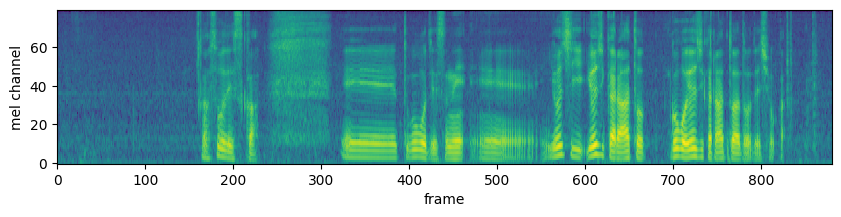

In [49]:
plt.figure(figsize=(10, 2))
plt.imshow(mspec[0].numpy().T, origin='lower', aspect='auto', interpolation='none')

plt.xlabel('frame')
plt.ylabel('mel channel')

横軸がフレーム，縦軸がメルチャネルになっているが，これだと理解が難しいので，
横軸を時間，縦軸を周波数に変換してプロットする．

In [8]:
def hz_to_mel_index(freq, n_mels=80, fmin=0, fmax=8000, htk=False):
    """周波数からメルチャネルのインデクス（実数値）を計算する．

    Args:
        freq (float or iterable): 周波数 [Hz] またはそのリスト
        n_mels (int): メルフィルタバンクの数
        fmin (float): メルスペクトログラムの最低周波数 [Hz]
        fmax (float): メルスペクトログラムの最大周波数 [Hz]
        htk (bool): HTK メルフィルタバンクを使うかどうか
    
    Returns:
        float or list: メルチャネルのインデクス（実数値）またはそのリスト
    """  
    def single_hz_to_mel_index(freq):
        if freq <= 0:
            return 0
        if freq > fmax:
            return n_mels
        mel_min = librosa.hz_to_mel(fmin, htk=htk)
        mel_max = librosa.hz_to_mel(fmax, htk=htk)
        mel = librosa.hz_to_mel(freq, htk=htk)
        idx = (mel - mel_min) / (mel_max - mel_min) * n_mels
        return idx

    if hasattr(freq, '__iter__'):
        return [single_hz_to_mel_index(f) for f in freq]
    else:
        return single_hz_to_mel_index(freq)

In [48]:
def show_mel_spectrogram(mel, ax, cmap="viridis", sr=16000, hop_length=160, fmin=0, fmax=8000, htk=False, show_xaxis=True):
    """メルスペクトログラムを表示する．

    Args:
        mel (numpy.ndarray): メルスペクトログラム
        ax (matplotlib.axes.Axes): 表示する Axes
        cmap (str): カラーマップ
        sr (int): サンプリング周波数 [Hz]
        hop_length (int): フレームの間隔
        fmin (float): メルスペクトログラムの最低周波数 [Hz]
        fmax (float): メルスペクトログラムの最大周波数 [Hz]
        htk (bool): HTK メルフィルタバンクを使うかどうか
    """    
    ax.imshow(mel, aspect="auto", origin="lower", cmap=cmap, interpolation='none',
              extent=(0, mel.shape[1]*hop_length/sr, 0, mel.shape[0]))
    
    n_mel = mel.shape[0]
    
    yticks_labels = [0] + [2**i for i in range(8, int(math.log2(sr/2))+1)] + [int(sr / 2)]
    yticks_possitions = hz_to_mel_index(yticks_labels, n_mel, fmax=sr / 2, htk=htk)

    ax.set_yticks(yticks_possitions, labels=yticks_labels)
    ax.set_ylim([0, n_mel])
    ax.set_ylabel("Frequency [Hz]")
    
    if show_xaxis:
        ax.set_xlabel("Time [sec]")
    else:
        ax.set_xticks([])

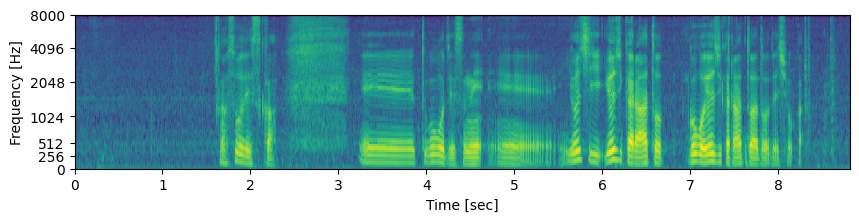

In [10]:
plt.figure(figsize=(10, 2))
show_mel_spectrogram(mspec[0].numpy().T, plt.gca(), sr=fs, hop_length=160, fmin=0, fmax=8000, htk=False, show_xaxis=True)

音声波形と重ねて表示する

In [11]:
def show_mel_spectrogram_with_sound(sounnd, mel, ax_sound, ax_mel, cmap="viridis", sr=16000, hop_length=160, fmin=0, fmax=8000, htk=False, show_mel_xaxis=False):
    show_mel_spectrogram(mel, ax_mel, cmap=cmap, sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax, htk=htk, show_xaxis=show_mel_xaxis)
    librosa.display.waveshow(sound, sr=sr, ax=ax_sound, color="blue", x_axis="time")

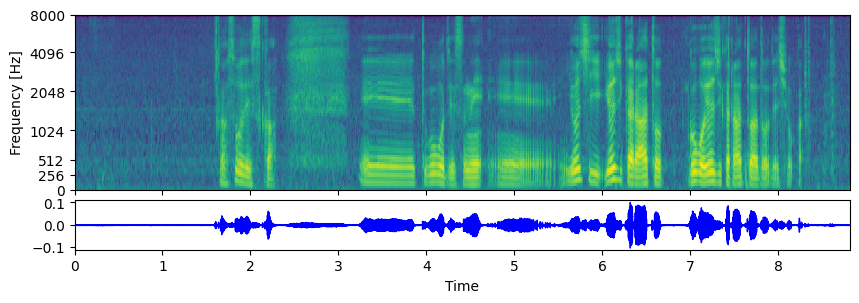

In [51]:
_, ax = plt.subplots(2, 1, figsize=(10, 2.5), sharex=True)
show_mel_spectrogram_with_sound(sound, mspec[0].numpy().T, ax[1], ax[0], sr=fs, hop_length=160, fmin=0, fmax=8000, htk=False, show_mel_xaxis=False)
# ax[0]とax[1]の高さを5:1にする
ax[0].set_position([0.125, 0.25, 0.775, 0.7])
ax[1].set_position([0.125, 0.01, 0.775, 0.2])
plt.show()
# 音声を表示する
display.display(display.Audio(sound, rate=fs))

## 複数のパラメータで比較する

In [53]:
# 窓400, FFT512, メルフィルタバンク80
frontend = DefaultFrontend(fs=16000, n_fft=512, hop_length=128, win_length=400, n_mels=80, htk=False)
msp_512_80, _ = frontend(sound_tensor, sound_lengths)
# 窓400, FFT512, メルフィルタバンク160
frontend = DefaultFrontend(fs=16000, n_fft=512, hop_length=128, win_length=400, n_mels=160, htk=False)
msp_512_160, _ = frontend(sound_tensor, sound_lengths)
# 窓800, FFT1024, メルフィルタバンク80
frontend = DefaultFrontend(fs=16000, n_fft=1024, hop_length=128, win_length=800, n_mels=80, htk=False)
msp_1024_80, _ = frontend(sound_tensor, sound_lengths)
# 窓800, FFT1024, メルフィルタバンク160
frontend = DefaultFrontend(fs=16000, n_fft=1024, hop_length=128, win_length=800, n_mels=160, htk=False)
msp_1024_160, _ = frontend(sound_tensor, sound_lengths)

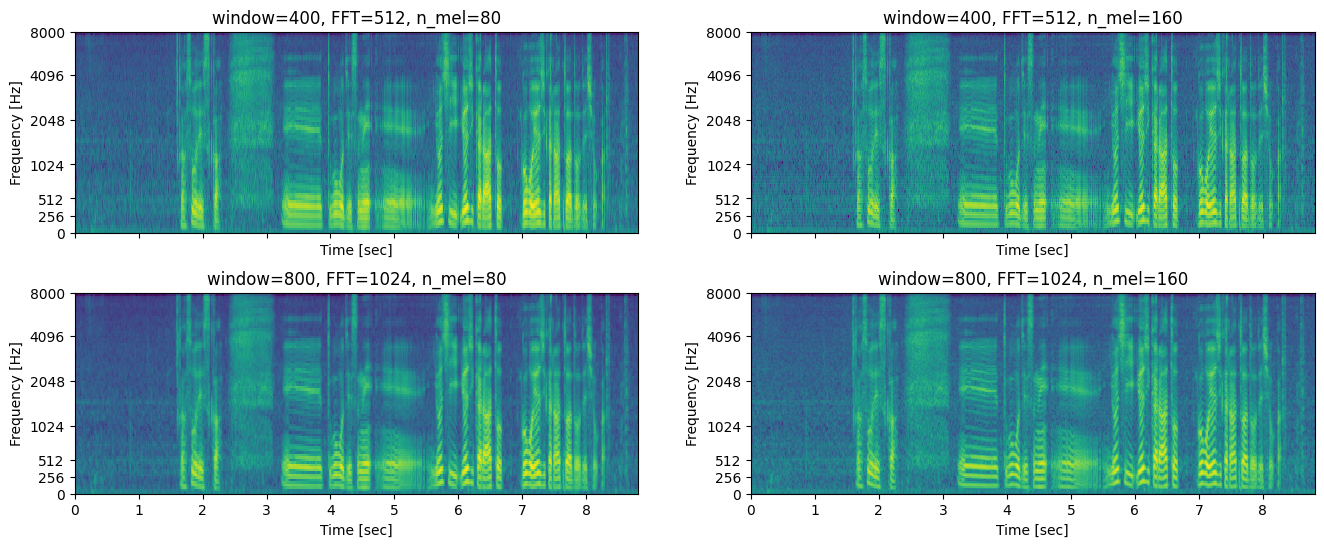

In [55]:
# 4つのスペクトルを比較
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 6), sharex=True, sharey=False)
# 中間のマージンを広くする
plt.subplots_adjust(wspace=0.2, hspace=0.3)

show_mel_spectrogram(msp_512_80[0].numpy().T, ax[0][0], cmap="viridis", sr=16000, hop_length=128, fmin=0, fmax=8000, htk=False)
ax[0, 0].set_title("window=400, FFT=512, n_mel=80")
show_mel_spectrogram(msp_512_160[0].numpy().T, ax[0][1], cmap="viridis", sr=16000, hop_length=128, fmin=0, fmax=8000, htk=False)
ax[0, 1].set_title("window=400, FFT=512, n_mel=160")
show_mel_spectrogram(msp_1024_80[0].numpy().T, ax[1][0], cmap="viridis", sr=16000, hop_length=128, fmin=0, fmax=8000, htk=False)
ax[1, 0].set_title("window=800, FFT=1024, n_mel=80")
show_mel_spectrogram(msp_1024_160[0].numpy().T, ax[1][1], cmap="viridis", sr=16000, hop_length=128, fmin=0, fmax=8000, htk=False)
ax[1, 1].set_title("window=800, FFT=1024, n_mel=160")

plt.show()

# SpecAug

In [ ]:
# SpecAug
specaug = SpecAug(time_mask_width_ratio_range=(0.0, 0.1), apply_time_warp=True, time_warp_window=5)

In [64]:
# 窓800, FFT1024, メルフィルタバンク160
frontend = DefaultFrontend(fs=16000, n_fft=1024, hop_length=128, win_length=800, n_mels=160, htk=False)
msp_1024_160, _ = frontend(sound_tensor, sound_lengths)
msp_1024_160_sa, _ = specaug(msp_1024_160, mspec_lengths)

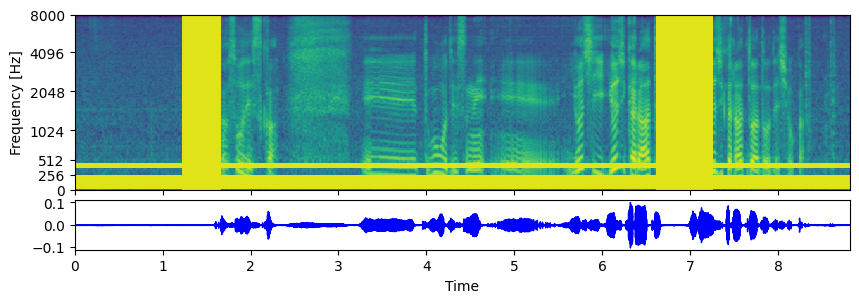

In [65]:
_, ax = plt.subplots(2, 1, figsize=(10, 2.5), sharex=True)
show_mel_spectrogram_with_sound(sound, msp_1024_160[0].numpy().T, ax[1], ax[0], sr=fs, hop_length=128, fmin=0, fmax=8000, htk=False, show_mel_xaxis=False)
# ax[0]とax[1]の高さを5:1にする
ax[0].set_position([0.125, 0.25, 0.775, 0.7])
ax[1].set_position([0.125, 0.01, 0.775, 0.2])
plt.show()
# 音声を表示する
display.display(display.Audio(sound, rate=fs))

In [63]:
from espnet2.tts.feats_extract.dio import Dio 

In [22]:
dio = Dio(fs=16000, n_fft=1024, hop_length=128, use_token_averaged_f0=False, use_continuous_f0=False, use_log_f0=True)

In [23]:
input_tensor = torch.tensor(sound, dtype=torch.float)
input_tensor = input_tensor.unsqueeze(0)
input_lengths = torch.tensor([input_tensor.shape[1]], dtype=torch.long)


In [24]:
f0, f0_lengths = dio(input_tensor, input_lengths)

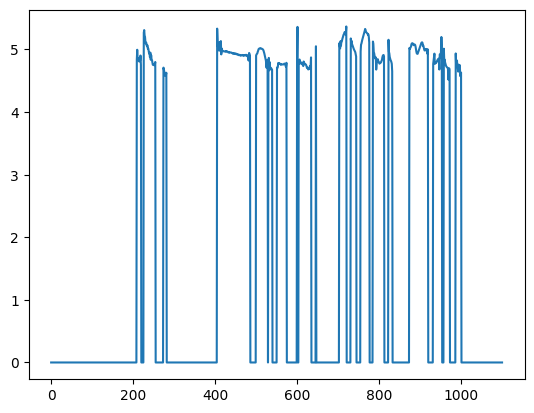

In [25]:
plt.plot(f0[0].squeeze(1))

In [26]:
# from espnet2.asr.encoder.conformer_encoder import ConformerEncoder

In [27]:
# encoder = ConformerEncoder(input_size=output.shape[-1])

In [28]:
# encoder_output, encoder_output_lengths, _ = encoder(output, output_lengths)

In [29]:
#print(output.shape)
#print(f0.shape)
#print(encoder_output.shape)

In [30]:
f0s = f0.squeeze(0, 2)
# f0sのサイズが4の倍数になるようにpadする
if f0s.shape[0] % 4 != 0:
    pad = 4 - f0s.shape[0] % 4
    f0s = torch.cat([f0s, torch.zeros(pad,)], dim=0)

In [31]:
f0s4 = f0s.reshape(-1, 4)
# 4つの値のうち，中央2つの平均値を計算する．
# ただし0は平均の計算に含めない．また，2つの値が両方とも0の場合は0を出力する．
f0p = f0s4[:, 1:3].clone()
f0p[f0p == 0] = float("nan")
f0p = torch.nanmean(f0p, dim=1)
f0p = torch.where(torch.isnan(f0p), torch.zeros_like(f0p), f0p)

In [32]:
# f0s4の4つの値を用いて最小自乗誤差法で傾きを計算する
# ただし，0の値は計算に含めない
# 3つ以上の値が0の場合は傾きは0とする
f0dy = f0s4.clone()
# f0dy[f0dy == 0] = float("nan")
f0dx = np.arange(f0dy.shape[1]) - (f0dy.shape[1]-1) / 2

In [33]:
f0ds = []
for i in range(f0dy.shape[0]):
    # fd0y[i]に含まれる0より大きい値の数を数える
    nonzero_count = torch.sum(f0dy[i] > 0)
    if nonzero_count > 2:
        dx = f0dx[f0dy[i] > 0]
        dy = f0dy[i][f0dy[i] > 0]
        # 傾きを計算する
        f0ds.append(np.polyfit(dx, dy, 1))
    else:
        f0ds.append([0.0, 0.0])
f0ds = np.stack(f0ds)
    

In [34]:
np.concatenate([f0p.unsqueeze(-1), f0ds], axis=1)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00

In [35]:
x = (np.arange(f0ds.shape[0]) * f0s4.shape[1] + (f0s4.shape[1]-1) / 2) * 8 / 1000

/tmp/ipykernel_190079/3677618492.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, f0ds[:, 1], 'ko', color='none', markeredgecolor='k')


(4.0, 6.0)

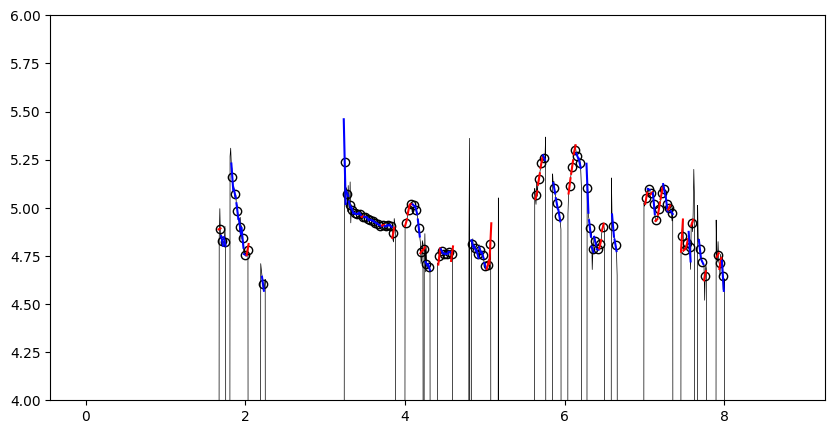

In [36]:
plt.figure(figsize=(10, 5))
f0sx = np.arange(f0s.shape[0]) * 8 / 1000
plt.plot(f0sx, f0s, 'k-', linewidth=0.5)
plt.plot(x, f0ds[:, 1], 'ko', color='none', markeredgecolor='k')
for i in range(f0ds.shape[0]):
    xx = [x[i] - 1.5 * 8 / 1000, x[i] + 1.5 * 8 / 1000] 
    yy = [f0ds[i, 1] - 1.5*f0ds[i, 0], f0ds[i, 1] + 1.5*f0ds[i, 0]]
    if f0ds[i, 0] >= 0:
        c = 'r'
    else:
        c = 'b'
    plt.plot(xx, yy, c + '-')
plt.ylim(4, 6)